In [1]:
# 隨機從dataset中挑選N筆資料
from os import walk
from os.path import join
from os import stat
import random
import hashlib
import time

mypath = "D:\Download\chunkhash\enron"

# store all the fullpath of files in the root directory
file_names = []


for root, dirs, files in walk(mypath):
    for f in files:
        fullpath = join(root, f)
        file_names.append(fullpath)

In [2]:
# store 1000 fullpath to upload
upload_files = []
# store 200 fullpath to check dulplicate
check_files = []

# three lists simulate cloud server
dirty_chunk = []
cloud_chunk = []
cloud_hash = []

# check file data
check_chunk = []
check_hash = []

In [3]:
# os.stat(file).st_size return size of the file in bytes
for i in range(1000):
    random_int = random.randint(0, len(file_names) - 1)
    upload_files.append(file_names[random_int])
    
for i in range(200):
    random_int = random.randint(0, len(file_names) - 1)
    check_files.append(file_names[random_int])
    
same_file = 0
for cf in check_files:
    if(cf in upload_files):
        same_file += 1
print('same file amount between cloud file and check file:', same_file)

same file amount between cloud file and check file: 1


In [4]:
def upload_file(upload_file_list, chunk_size):
    for file in upload_file_list:
        with open(file, 'rb') as f:
            text = f.read()
        f.close()

        if(len(text) % chunk_size != 0):
            for i in range(chunk_size - (len(text) % chunk_size)):
                text += bytes.fromhex('30')
        
        text_chunk = []
        for i in range(0, len(text), chunk_size):
            text_chunk.append(text[i: i + chunk_size])
        cloud_chunk.extend(text_chunk)
        
        text_hash = []
        for i in range(len(text_chunk)):
            hash_text = hashlib.sha256(text_chunk[i]).hexdigest()
            text_hash.append(hash_text)
        cloud_hash.extend(text_hash)
        
def cut_check_file(check_file_list, chunk_size):
    for file in check_file_list:
        with open(file, 'rb') as f:
            text = f.read()
        f.close()
        
        if(len(text) % chunk_size != 0):
            for j in range(chunk_size - (len(text) % chunk_size)):
                text += bytes.fromhex('30')
        
        text_chunk = []
        for i in range(0, len(text), chunk_size):
            text_chunk.append(text[i: i + chunk_size])
            
        if(len(text_chunk) % 2 != 0):
            rand_chunk = text_chunk[random.randint(0, len(text_chunk) - 1)]
            text_chunk.append(rand_chunk)
        check_chunk.extend(text_chunk)
        
        text_hash = []
        for i in range(len(text_chunk)):
            hash_text = hashlib.sha256(text_chunk[i]).hexdigest()
            text_hash.append(hash_text)
        check_hash.extend(text_hash)

In [5]:
def set_dirty_chunk(dirty_percent):
    for i in range(int(len(cloud_hash) * dirty_percent)):
        dirty_chunk.append(cloud_hash[random.randint(0, len(cloud_hash) - 1)])

def zeus_check(chunk1, chunk2, hash_list):
    num = 0
    existence = 0
    for i in range(len(hash_list)):
        if(chunk1 == hash_list[i][0]):
            existence += 1
            if(hash_list[i][1] > 0):
                hash_list[i][1] -=1
            else:
                num += 1
            break
    if(existence < 1):
        hash_list.append([chunk1, 0])
    for i in range(len(hash_list)):
        if(chunk2 == hash_list[i][0]):
            existence += 1
            if(hash_list[i][1] > 0):
                hash_list[i][1] -=1
            else:
                num += 1
            break
    if(existence < 2):
        hash_list.append([chunk2, 0])
        
    return num

def zeus(chunk1, chunk2, hash_list):
    num = 0
    if(chunk1 in hash_list):
        num += 1
    else:
        hash_list.append(chunk1)
    if(chunk2 in hash_list):
        num += 1
    else:
        hash_list.append(chunk2)
    
    return num

def cal_commu_cost(chunk_size, is_zeus, has_dirty, thresh_max):
    upload_time = 0
    cost = 0
    cloud_copy = cloud_chunk.copy()
    hash_copy = cloud_hash.copy()
    dirty_copy = dirty_chunk.copy()
    
#     start_time = time.time()
    
    if(thresh_max > 0):
        for i in range(len(hash_copy)):
            hash_copy[i] = [hash_copy[i], random.randint(1, thresh_max)]
   
    if(is_zeus and thresh_max > 0):
        for i in range(0, len(check_hash), 2):
            cost += 64
            if(has_dirty):
                if((check_hash[i] in dirty_copy) or (check_hash[i + 1] in dirty_copy)):
                    cloud_copy.append(check_chunk[i])
                    cloud_copy.append(check_chunk[i + 1])
                    if(check_hash[i] in dirty_copy):
                        dirty_copy.remove(check_hash[i])
                    if(check_hash[i + 1] in dirty_copy):
                        dirty_copy.remove(check_hash[i + 1])
                    val = zeus_check(check_hash[i], check_hash[i + 1], hash_copy)
                    cost += chunk_size * 2
                    upload_time += 2
                    continue
                    
            val = zeus_check(check_hash[i], check_hash[i + 1], hash_copy)
            if(val == 0):
                cloud_copy.append(check_chunk[i])
                cloud_copy.append(check_chunk[i + 1])
                cost += chunk_size * 2
                upload_time += 2
            else:
                xor_result = hex(int(check_chunk[i].hex(), 16) ^ int(check_chunk[i + 1].hex(), 16))[2:]
                if(len(xor_result) < (chunk_size * 2)):
                    for i in range((chunk_size * 2) - len(xor_result)):
                        xor_result = '0' + xor_result
                cloud_copy.append(bytes.fromhex(xor_result))
                cost += chunk_size
                upload_time += 1
                    
    if(is_zeus and thresh_max == 0):
        for i in range(0, len(check_hash), 2):
            cost += 64
            if(has_dirty):
                if((check_hash[i] in dirty_copy) or (check_hash[i + 1] in dirty_copy)):
                    cloud_copy.append(check_chunk[i])
                    cloud_copy.append(check_chunk[i + 1])
                    if(check_hash[i] in dirty_copy):
                        dirty_copy.remove(check_hash[i])
                    if(check_hash[i] not in hash_copy):
                        hash_copy.append(check_hash[i])
                    if(check_hash[i + 1] in dirty_copy):
                        dirty_copy.remove(check_hash[i + 1])
                    if(check_hash[i + 1] not in hash_copy):
                        hash_copy.append(check_hash[i + 1])
                    cost += chunk_size * 2
                    upload_time += 2
                    continue
                    
            val = zeus(check_hash[i], check_hash[i + 1], hash_copy)        
            if(val == 0):
                cloud_copy.append(check_chunk[i])
                cloud_copy.append(check_chunk[i + 1])
                cost += chunk_size * 2
                upload_time += 2
            else:
                xor_result = hex(int(check_chunk[i].hex(), 16) ^ int(check_chunk[i + 1].hex(), 16))[2:]
                if(len(xor_result) < (chunk_size * 2)):
                    for i in range((chunk_size * 2) - len(xor_result)):
                        xor_result = '0' + xor_result
                cloud_copy.append(bytes.fromhex(xor_result))
                cost += chunk_size
                upload_time += 1
    if(not is_zeus):
        for i in range(len(check_hash)):
            cost += 32
            if(has_dirty):
                if(check_hash[i] in dirty_copy):
                    cloud_copy.append(check_chunk[i])
                    dirty_copy.remove(check_hash[i])
                    if(check_hash[i] not in hash_copy):
                        hash_copy.append(check_hash[i])
                    cost += chunk_size
                    upload_time += 1
                    continue
            if(check_hash[i] not in hash_copy):
                cloud_copy.append(check_chunk[i])
                hash_copy.append(check_hash[i])
                cost += chunk_size
                upload_time += 1
                
#     end_time = time.time()
    if(has_dirty):
        if(is_zeus):
            if(thresh_max > 0):
                print('dirty ZEUS having threshold %d, with chunk size: %d bytes, dedup times: %d, check times: %d, dedup percentage: %f %%' % (thresh_max, chunk_size, len(check_hash) - upload_time, len(check_hash), ((len(check_hash) - upload_time) / len(check_hash)) * 100))
            else:
                print('dirty ZEUS with chunk size: %d bytes, dedup times: %d, check times: %d, dedup percentage: %f %%' % (chunk_size, len(check_hash) - upload_time, len(check_hash), ((len(check_hash) - upload_time) / len(check_hash)) * 100))
        else:
            print('dirty original dedup with chunk size: %d bytes, dedup times: %d, check times: %d, dedup percentage: %f %%' % (chunk_size, len(check_hash) - upload_time, len(check_hash), ((len(check_hash) - upload_time) / len(check_hash)) * 100))
    elif(is_zeus):
        if(thresh_max > 0):
            print('ZEUS having threshold %d, with chunk size: %d bytes, dedup times: %d, check times: %d, dedup percentage: %f %%' % (thresh_max, chunk_size, len(check_hash) - upload_time, len(check_hash), ((len(check_hash) - upload_time) / len(check_hash)) * 100))
        else:
            print('ZEUS with chunk size: %d bytes, dedup times: %d, check times: %d, dedup percentage: %f %%' % (chunk_size, len(check_hash) - upload_time, len(check_hash), ((len(check_hash) - upload_time) / len(check_hash)) * 100))
    else:
        print('origin dedup with chunk size: %d bytes,  dedup times: %d, check times: %d, dedup percentage: %f %%' % (chunk_size, len(check_hash) - upload_time, len(check_hash), ((len(check_hash) - upload_time) / len(check_hash)) * 100))
    
    cost -= len(check_hash) * 32
    return cost

In [6]:
def rare(chunk1, chunk2, hash_list):
    num = 0
    if(chunk1 in hash_list):
        num += 1
    else:
        hash_list.append(chunk1)
    if(chunk2 in hash_list):
        num += 1
    else:
        hash_list.append(chunk2)
    
    if(num == 0):
        return 2
    else:
        val = random.randint(1, 2)
        return val

def rare_cost(chunk_size, do_dedup, do_rare, has_dirty):
    upload_time = 0
    cost = 0
    cloud_copy = cloud_chunk.copy()
    hash_copy = cloud_hash.copy()
    dirty_copy = dirty_chunk.copy()
    
#     start_time = time.time()
    
    if(do_dedup and do_rare):        
        for i in range(0, len(check_hash), 2):
            cost += 64
            if(has_dirty):
                if((check_hash[i] in dirty_copy) or (check_hash[i + 1] in dirty_copy)):
                    cloud_copy.append(check_chunk[i])
                    cloud_copy.append(check_chunk[i + 1])
                    if(check_hash[i] in dirty_copy):
                        dirty_copy.remove(check_hash[i])
                    if(check_hash[i] not in hash_copy):
                        hash_copy.append(check_hash[i])
                    if(check_hash[i + 1] in dirty_copy):
                        dirty_copy.remove(check_hash[i + 1])
                    if(check_hash[i + 1] not in hash_copy):
                        hash_copy.append(check_hash[i + 1])
                    cost += chunk_size * 2
                    upload_time += 2
                    continue
            
            val = rare(check_hash[i], check_hash[i + 1], hash_copy)
            if(val == 2):
                cloud_copy.append(check_chunk[i])
                cloud_copy.append(check_chunk[i + 1])
                cost += chunk_size * 2
                upload_time += 2
            else:
                xor_result = hex(int(check_chunk[i].hex(), 16) ^ int(check_chunk[i + 1].hex(), 16))[2:]
                if(len(xor_result) < (chunk_size * 2)):
                    for i in range((chunk_size * 2) - len(xor_result)):
                        xor_result = '0' + xor_result
                cloud_copy.append(bytes.fromhex(xor_result))
                cost += chunk_size
                upload_time += 1
    if(do_dedup and (not do_rare)):
        for i in range(len(check_hash)):
            cost += 32
            if(has_dirty):
                if(check_hash[i] in dirty_copy):
                    cloud_copy.append(check_chunk[i])
                    dirty_copy.remove(check_hash[i])
                    cost += chunk_size
                    upload_time += 1
                    if(check_hash[i] not in hash_copy):
                        hash_copy.append(check_hash[i])
                    continue
                
            if(check_hash[i] not in hash_copy):
                cloud_copy.append(check_chunk[i])
                hash_copy.append(check_hash[i])
                cost += chunk_size
                upload_time += 1
    if(not do_dedup):
        cost = (32 + chunk_size) * len(check_hash)
        upload_time += len(check_hash)
    
#     end_time = time.time()
    if(has_dirty):
        if(do_rare):
            print('dirty RARE with chunk size: %d bytes, dedup times: %d, check times: %d, dedup percentage: %f %%' % (chunk_size, len(check_hash) - upload_time, len(check_hash), ((len(check_hash) - upload_time) / len(check_hash)) * 100))
        else:
            print('dirty original dedup with chunk size: %d bytes, dedup times: %d, check times: %d, dedup percentage: %f %%' % (chunk_size, len(check_hash) - upload_time, len(check_hash), ((len(check_hash) - upload_time) / len(check_hash)) * 100))
    elif(do_rare):
        print('RARE with chunk size: %d bytes, dedup times: %d, check times: %d, dedup percentage: %f %%' % (chunk_size, len(check_hash) - upload_time, len(check_hash), ((len(check_hash) - upload_time) / len(check_hash)) * 100))
    elif(do_dedup):
        print('origin dedup with chunk size: %d bytes, dedup times: %d, check times: %d, dedup percentage: %f %%' % (chunk_size, len(check_hash) - upload_time, len(check_hash), ((len(check_hash) - upload_time) / len(check_hash)) * 100))
    else:
        print('no dedup with chunk size: %d bytes, dedup times: %d, check times: %d, dedup percentage: %f %%' % (chunk_size, len(check_hash) - upload_time, len(check_hash), ((len(check_hash) - upload_time) / len(check_hash)) * 100))
    
    cost -= len(check_hash) * 32
    return cost

In [7]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

origin_costs = []
zeus_costs = []
zeus5_costs = []
zeus20_costs = []
zeus40_costs = []

no_dedup_costs = []
origin_dedup_costs = []
rare_costs = []

# no dirty chunk 128B
upload_file(upload_files, 128)
cut_check_file(check_files, 128)
origin_costs.append(cal_commu_cost(128, False, False, 0))
zeus_costs.append(cal_commu_cost(128, True, False, 0))
zeus5_costs.append(cal_commu_cost(128, True, False, 5))
zeus20_costs.append(cal_commu_cost(128, True, False, 20))
zeus40_costs.append(cal_commu_cost(128, True, False, 40))

no_dedup_costs.append(rare_cost(128, False, False, False))
origin_dedup_costs.append(rare_cost(128, True, False, False))
rare_costs.append(rare_cost(128, True, True, False))

origin dedup with chunk size: 128 bytes,  dedup times: 193, check times: 5900, dedup percentage: 3.271186 %
ZEUS with chunk size: 128 bytes, dedup times: 153, check times: 5900, dedup percentage: 2.593220 %
ZEUS having threshold 5, with chunk size: 128 bytes, dedup times: 111, check times: 5900, dedup percentage: 1.881356 %
ZEUS having threshold 20, with chunk size: 128 bytes, dedup times: 101, check times: 5900, dedup percentage: 1.711864 %
ZEUS having threshold 40, with chunk size: 128 bytes, dedup times: 102, check times: 5900, dedup percentage: 1.728814 %
no dedup with chunk size: 128 bytes, dedup times: 0, check times: 5900, dedup percentage: 0.000000 %
origin dedup with chunk size: 128 bytes, dedup times: 193, check times: 5900, dedup percentage: 3.271186 %
RARE with chunk size: 128 bytes, dedup times: 82, check times: 5900, dedup percentage: 1.389831 %


In [8]:
# print(len(cloud_chunk), len(cloud_hash))
# print(len(check_chunk), len(check_hash))
# amount = 0
# for chunk in check_chunk:
#     if(chunk in cloud_chunk):
#         amount += 1
# hash_amount = 0
# for h in check_hash:
#     if(h in cloud_hash):
#         hash_amount += 1
# print(amount, hash_amount)
# print('%.2f' %(amount * 100 / len(check_chunk)) + '%', '%.2f' %(hash_amount * 100 / len(check_hash)) + '%')

In [9]:
# print(origin_costs)
# print(zeus_costs)
# print(zeus5_costs)
# print(zeus20_costs)
# print(zeus40_costs)
# print('-----------')
# print(no_dedup_costs)
# print(origin_dedup_costs)
# print(rare_costs)

In [10]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# no dirty chunk 256B
upload_file(upload_files, 256)
cut_check_file(check_files, 256)
origin_costs.append(cal_commu_cost(256, False, False, 0))
zeus_costs.append(cal_commu_cost(256, True, False, 0))
zeus5_costs.append(cal_commu_cost(256, True, False, 5))
zeus20_costs.append(cal_commu_cost(256, True, False, 20))
zeus40_costs.append(cal_commu_cost(256, True, False, 40))

no_dedup_costs.append(rare_cost(256, False, False, False))
origin_dedup_costs.append(rare_cost(256, True, False, False))
rare_costs.append(rare_cost(256, True, True, False))

origin dedup with chunk size: 256 bytes,  dedup times: 147, check times: 3058, dedup percentage: 4.807063 %
ZEUS with chunk size: 256 bytes, dedup times: 132, check times: 3058, dedup percentage: 4.316547 %
ZEUS having threshold 5, with chunk size: 256 bytes, dedup times: 115, check times: 3058, dedup percentage: 3.760628 %
ZEUS having threshold 20, with chunk size: 256 bytes, dedup times: 107, check times: 3058, dedup percentage: 3.499019 %
ZEUS having threshold 40, with chunk size: 256 bytes, dedup times: 109, check times: 3058, dedup percentage: 3.564421 %
no dedup with chunk size: 256 bytes, dedup times: 0, check times: 3058, dedup percentage: 0.000000 %
origin dedup with chunk size: 256 bytes, dedup times: 147, check times: 3058, dedup percentage: 4.807063 %
RARE with chunk size: 256 bytes, dedup times: 67, check times: 3058, dedup percentage: 2.190974 %


In [11]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# no dirty chunk 512B
upload_file(upload_files, 512)
cut_check_file(check_files, 512)
origin_costs.append(cal_commu_cost(512, False, False, 0))
zeus_costs.append(cal_commu_cost(512, True, False, 0))
zeus5_costs.append(cal_commu_cost(512, True, False, 5))
zeus20_costs.append(cal_commu_cost(512, True, False, 20))
zeus40_costs.append(cal_commu_cost(512, True, False, 40))

no_dedup_costs.append(rare_cost(512, False, False, False))
origin_dedup_costs.append(rare_cost(512, True, False, False))
rare_costs.append(rare_cost(512, True, True, False))

origin dedup with chunk size: 512 bytes,  dedup times: 96, check times: 1610, dedup percentage: 5.962733 %
ZEUS with chunk size: 512 bytes, dedup times: 91, check times: 1610, dedup percentage: 5.652174 %
ZEUS having threshold 5, with chunk size: 512 bytes, dedup times: 83, check times: 1610, dedup percentage: 5.155280 %
ZEUS having threshold 20, with chunk size: 512 bytes, dedup times: 81, check times: 1610, dedup percentage: 5.031056 %
ZEUS having threshold 40, with chunk size: 512 bytes, dedup times: 81, check times: 1610, dedup percentage: 5.031056 %
no dedup with chunk size: 512 bytes, dedup times: 0, check times: 1610, dedup percentage: 0.000000 %
origin dedup with chunk size: 512 bytes, dedup times: 96, check times: 1610, dedup percentage: 5.962733 %
RARE with chunk size: 512 bytes, dedup times: 49, check times: 1610, dedup percentage: 3.043478 %


In [12]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# no dirty chunk 1KB
upload_file(upload_files, 1024)
cut_check_file(check_files, 1024)
origin_costs.append(cal_commu_cost(1024, False, False, 0))
zeus_costs.append(cal_commu_cost(1024, True, False, 0))
zeus5_costs.append(cal_commu_cost(1024, True, False, 5))
zeus20_costs.append(cal_commu_cost(1024, True, False, 20))
zeus40_costs.append(cal_commu_cost(1024, True, False, 40))

no_dedup_costs.append(rare_cost(1024, False, False, False))
origin_dedup_costs.append(rare_cost(1024, True, False, False))
rare_costs.append(rare_cost(1024, True, True, False))

origin dedup with chunk size: 1024 bytes,  dedup times: 114, check times: 914, dedup percentage: 12.472648 %
ZEUS with chunk size: 1024 bytes, dedup times: 112, check times: 914, dedup percentage: 12.253829 %
ZEUS having threshold 5, with chunk size: 1024 bytes, dedup times: 109, check times: 914, dedup percentage: 11.925602 %
ZEUS having threshold 20, with chunk size: 1024 bytes, dedup times: 109, check times: 914, dedup percentage: 11.925602 %
ZEUS having threshold 40, with chunk size: 1024 bytes, dedup times: 109, check times: 914, dedup percentage: 11.925602 %
no dedup with chunk size: 1024 bytes, dedup times: 0, check times: 914, dedup percentage: 0.000000 %
origin dedup with chunk size: 1024 bytes, dedup times: 114, check times: 914, dedup percentage: 12.472648 %
RARE with chunk size: 1024 bytes, dedup times: 56, check times: 914, dedup percentage: 6.126915 %


In [13]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# no dirty chunk 2KB
upload_file(upload_files, 2048)
cut_check_file(check_files, 2048)
origin_costs.append(cal_commu_cost(2048, False, False, 0))
zeus_costs.append(cal_commu_cost(2048, True, False, 0))
zeus5_costs.append(cal_commu_cost(2048, True, False, 5))
zeus20_costs.append(cal_commu_cost(2048, True, False, 20))
zeus40_costs.append(cal_commu_cost(2048, True, False, 40))

no_dedup_costs.append(rare_cost(2048, False, False, False))
origin_dedup_costs.append(rare_cost(2048, True, False, False))
rare_costs.append(rare_cost(2048, True, True, False))

origin dedup with chunk size: 2048 bytes,  dedup times: 145, check times: 600, dedup percentage: 24.166667 %
ZEUS with chunk size: 2048 bytes, dedup times: 144, check times: 600, dedup percentage: 24.000000 %
ZEUS having threshold 5, with chunk size: 2048 bytes, dedup times: 142, check times: 600, dedup percentage: 23.666667 %
ZEUS having threshold 20, with chunk size: 2048 bytes, dedup times: 142, check times: 600, dedup percentage: 23.666667 %
ZEUS having threshold 40, with chunk size: 2048 bytes, dedup times: 141, check times: 600, dedup percentage: 23.500000 %
no dedup with chunk size: 2048 bytes, dedup times: 0, check times: 600, dedup percentage: 0.000000 %
origin dedup with chunk size: 2048 bytes, dedup times: 145, check times: 600, dedup percentage: 24.166667 %
RARE with chunk size: 2048 bytes, dedup times: 84, check times: 600, dedup percentage: 14.000000 %


In [14]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# no dirty chunk 4KB
upload_file(upload_files, 4096)
cut_check_file(check_files, 4096)
origin_costs.append(cal_commu_cost(4096, False, False, 0))
zeus_costs.append(cal_commu_cost(4096, True, False, 0))
zeus5_costs.append(cal_commu_cost(4096, True, False, 5))
zeus20_costs.append(cal_commu_cost(4096, True, False, 20))
zeus40_costs.append(cal_commu_cost(4096, True, False, 40))

no_dedup_costs.append(rare_cost(4096, False, False, False))
origin_dedup_costs.append(rare_cost(4096, True, False, False))
rare_costs.append(rare_cost(4096, True, True, False))

origin dedup with chunk size: 4096 bytes,  dedup times: 167, check times: 466, dedup percentage: 35.836910 %
ZEUS with chunk size: 4096 bytes, dedup times: 166, check times: 466, dedup percentage: 35.622318 %
ZEUS having threshold 5, with chunk size: 4096 bytes, dedup times: 165, check times: 466, dedup percentage: 35.407725 %
ZEUS having threshold 20, with chunk size: 4096 bytes, dedup times: 165, check times: 466, dedup percentage: 35.407725 %
ZEUS having threshold 40, with chunk size: 4096 bytes, dedup times: 165, check times: 466, dedup percentage: 35.407725 %
no dedup with chunk size: 4096 bytes, dedup times: 0, check times: 466, dedup percentage: 0.000000 %
origin dedup with chunk size: 4096 bytes, dedup times: 167, check times: 466, dedup percentage: 35.836910 %
RARE with chunk size: 4096 bytes, dedup times: 78, check times: 466, dedup percentage: 16.738197 %


Origin Data Dedup: [730496, 745216, 775168, 819200, 931840, 1224704]
ZEUS:              [735616, 749056, 777728, 821248, 933888, 1228800]
ZEUS+(B=5):        [740992, 753408, 781824, 824320, 937984, 1232896]
ZEUS+(B=20):       [742272, 755456, 782848, 824320, 937984, 1232896]
ZEUS+(B=40):       [742144, 754944, 782848, 824320, 940032, 1232896]
-------------
Without Data Dedup: [755200, 782848, 824320, 935936, 1228800, 1908736]
Rare:               [744704, 765696, 799232, 878592, 1056768, 1589248]
Origin Data Dedup:  [730496, 745216, 775168, 819200, 931840, 1224704]


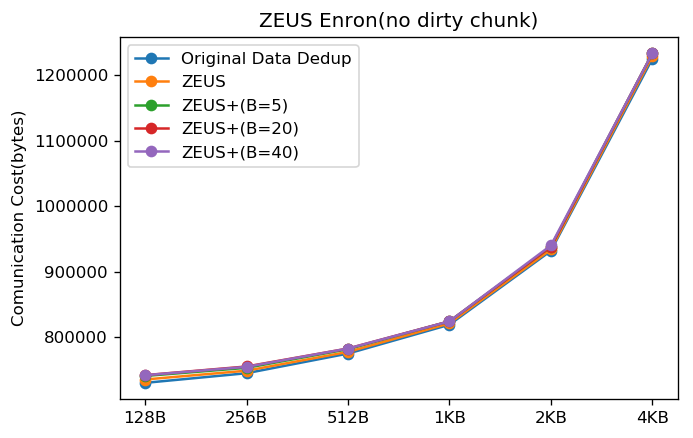

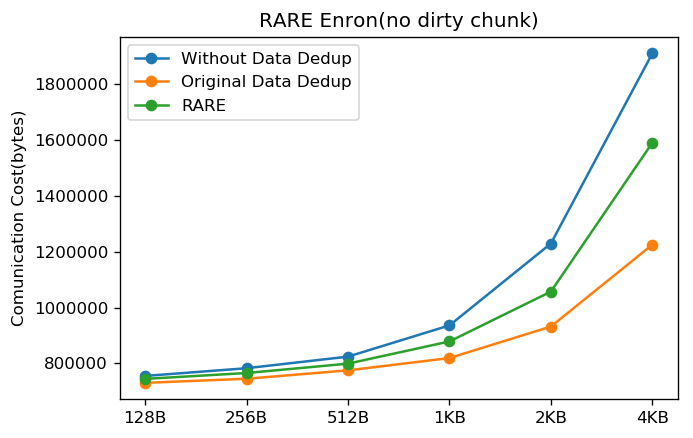

In [15]:
no_dirty = [origin_costs.copy(), zeus_costs.copy(), zeus5_costs.copy(), zeus20_costs.copy(), zeus40_costs.copy()]
no_dirty_rare = [no_dedup_costs.copy(), origin_dedup_costs.copy(), rare_costs.copy()]

print("Origin Data Dedup:", origin_costs)
print("ZEUS:             ", zeus_costs)
print("ZEUS+(B=5):       ", zeus5_costs)
print("ZEUS+(B=20):      ", zeus20_costs)
print("ZEUS+(B=40):      ", zeus40_costs)
print('-------------')
print("Without Data Dedup:", no_dedup_costs)
print("Rare:              ", rare_costs)
print("Origin Data Dedup: ", origin_dedup_costs)


%matplotlib inline
import matplotlib.pyplot as plt 
plt.figure(dpi = 120)
x = ['128B', '256B', '512B', '1KB', '2KB', '4KB']
plt.plot(x, origin_costs,  '-o', label = 'Original Data Dedup')
plt.plot(x, zeus_costs,  '-o', label = 'ZEUS')
plt.plot(x, zeus5_costs,  '-o', label = 'ZEUS+(B=5)')
plt.plot(x, zeus20_costs,  '-o', label = 'ZEUS+(B=20)')
plt.plot(x, zeus40_costs,  '-o', label = 'ZEUS+(B=40)')
plt.legend()
plt.ylabel('Comunication Cost(bytes)')
plt.title('ZEUS Enron(no dirty chunk)')
plt.show()

plt.figure(dpi = 120)
plt.plot(x, no_dedup_costs, '-o', label = 'Without Data Dedup')
plt.plot(x, origin_dedup_costs, '-o', label = 'Original Data Dedup')
plt.plot(x, rare_costs, '-o', label = 'RARE')
plt.legend()
plt.ylabel('Comunication Cost(bytes)')
plt.title('RARE Enron(no dirty chunk)')
plt.show()

In [16]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

origin_costs.clear()
zeus_costs.clear()
zeus5_costs.clear()
zeus20_costs.clear()
zeus40_costs.clear()

no_dedup_costs.clear()
origin_dedup_costs.clear()
rare_costs.clear()

# 10% dirty chunk 128B
upload_file(upload_files, 128)
cut_check_file(check_files, 128)
set_dirty_chunk(0.1)
origin_costs.append(cal_commu_cost(128, False, True, 0))
zeus_costs.append(cal_commu_cost(128, True, True, 0))
zeus5_costs.append(cal_commu_cost(128, True, True, 5))
zeus20_costs.append(cal_commu_cost(128, True, True, 20))
zeus40_costs.append(cal_commu_cost(128, True, True, 40))

no_dedup_costs.append(rare_cost(128, False, False, False))
origin_dedup_costs.append(rare_cost(128, True, False, True))
rare_costs.append(rare_cost(128, True, True, True))

dirty original dedup with chunk size: 128 bytes, dedup times: 187, check times: 5900, dedup percentage: 3.169492 %
dirty ZEUS with chunk size: 128 bytes, dedup times: 147, check times: 5900, dedup percentage: 2.491525 %
dirty ZEUS having threshold 5, with chunk size: 128 bytes, dedup times: 107, check times: 5900, dedup percentage: 1.813559 %
dirty ZEUS having threshold 20, with chunk size: 128 bytes, dedup times: 100, check times: 5900, dedup percentage: 1.694915 %
dirty ZEUS having threshold 40, with chunk size: 128 bytes, dedup times: 100, check times: 5900, dedup percentage: 1.694915 %
no dedup with chunk size: 128 bytes, dedup times: 0, check times: 5900, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 128 bytes, dedup times: 187, check times: 5900, dedup percentage: 3.169492 %
dirty RARE with chunk size: 128 bytes, dedup times: 71, check times: 5900, dedup percentage: 1.203390 %


In [17]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# 10% dirty chunk 256B
upload_file(upload_files, 256)
cut_check_file(check_files, 256)
set_dirty_chunk(0.1)
origin_costs.append(cal_commu_cost(256, False, True, 0))
zeus_costs.append(cal_commu_cost(256, True, True, 0))
zeus5_costs.append(cal_commu_cost(256, True, True, 5))
zeus20_costs.append(cal_commu_cost(256, True, True, 20))
zeus40_costs.append(cal_commu_cost(256, True, True, 40))
no_dedup_costs.append(rare_cost(256, False, False, False))
origin_dedup_costs.append(rare_cost(256, True, False, True))
rare_costs.append(rare_cost(256, True, True, True))

dirty original dedup with chunk size: 256 bytes, dedup times: 142, check times: 3058, dedup percentage: 4.643558 %
dirty ZEUS with chunk size: 256 bytes, dedup times: 128, check times: 3058, dedup percentage: 4.185742 %
dirty ZEUS having threshold 5, with chunk size: 256 bytes, dedup times: 113, check times: 3058, dedup percentage: 3.695226 %
dirty ZEUS having threshold 20, with chunk size: 256 bytes, dedup times: 110, check times: 3058, dedup percentage: 3.597122 %
dirty ZEUS having threshold 40, with chunk size: 256 bytes, dedup times: 108, check times: 3058, dedup percentage: 3.531720 %
no dedup with chunk size: 256 bytes, dedup times: 0, check times: 3058, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 256 bytes, dedup times: 142, check times: 3058, dedup percentage: 4.643558 %
dirty RARE with chunk size: 256 bytes, dedup times: 74, check times: 3058, dedup percentage: 2.419882 %


In [18]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# 10% dirty chunk 512B
upload_file(upload_files, 512)
cut_check_file(check_files, 512)
set_dirty_chunk(0.1)
origin_costs.append(cal_commu_cost(512, False, True, 0))
zeus_costs.append(cal_commu_cost(512, True, True, 0))
zeus5_costs.append(cal_commu_cost(512, True, True, 5))
zeus20_costs.append(cal_commu_cost(512, True, True, 20))
zeus40_costs.append(cal_commu_cost(512, True, True, 40))
no_dedup_costs.append(rare_cost(512, False, False, False))
origin_dedup_costs.append(rare_cost(512, True, False, True))
rare_costs.append(rare_cost(512, True, True, True))

dirty original dedup with chunk size: 512 bytes, dedup times: 96, check times: 1610, dedup percentage: 5.962733 %
dirty ZEUS with chunk size: 512 bytes, dedup times: 91, check times: 1610, dedup percentage: 5.652174 %
dirty ZEUS having threshold 5, with chunk size: 512 bytes, dedup times: 82, check times: 1610, dedup percentage: 5.093168 %
dirty ZEUS having threshold 20, with chunk size: 512 bytes, dedup times: 80, check times: 1610, dedup percentage: 4.968944 %
dirty ZEUS having threshold 40, with chunk size: 512 bytes, dedup times: 81, check times: 1610, dedup percentage: 5.031056 %
no dedup with chunk size: 512 bytes, dedup times: 0, check times: 1610, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 512 bytes, dedup times: 96, check times: 1610, dedup percentage: 5.962733 %
dirty RARE with chunk size: 512 bytes, dedup times: 54, check times: 1610, dedup percentage: 3.354037 %


In [19]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# 10% dirty chunk 1KB
upload_file(upload_files, 1024)
cut_check_file(check_files, 1024)
set_dirty_chunk(0.1)
origin_costs.append(cal_commu_cost(1024, False, True, 0))
zeus_costs.append(cal_commu_cost(1024, True, True, 0))
zeus5_costs.append(cal_commu_cost(1024, True, True, 5))
zeus20_costs.append(cal_commu_cost(1024, True, True, 20))
zeus40_costs.append(cal_commu_cost(1024, True, True, 40))
no_dedup_costs.append(rare_cost(1024, False, False, False))
origin_dedup_costs.append(rare_cost(1024, True, False, True))
rare_costs.append(rare_cost(1024, True, True, True))

dirty original dedup with chunk size: 1024 bytes, dedup times: 114, check times: 914, dedup percentage: 12.472648 %
dirty ZEUS with chunk size: 1024 bytes, dedup times: 112, check times: 914, dedup percentage: 12.253829 %
dirty ZEUS having threshold 5, with chunk size: 1024 bytes, dedup times: 109, check times: 914, dedup percentage: 11.925602 %
dirty ZEUS having threshold 20, with chunk size: 1024 bytes, dedup times: 109, check times: 914, dedup percentage: 11.925602 %
dirty ZEUS having threshold 40, with chunk size: 1024 bytes, dedup times: 109, check times: 914, dedup percentage: 11.925602 %
no dedup with chunk size: 1024 bytes, dedup times: 0, check times: 914, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 1024 bytes, dedup times: 114, check times: 914, dedup percentage: 12.472648 %
dirty RARE with chunk size: 1024 bytes, dedup times: 58, check times: 914, dedup percentage: 6.345733 %


In [20]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# 10% dirty chunk 2KB
upload_file(upload_files, 2048)
cut_check_file(check_files, 2048)
set_dirty_chunk(0.1)
origin_costs.append(cal_commu_cost(2048, False, True, 0))
zeus_costs.append(cal_commu_cost(2048, True, True, 0))
zeus5_costs.append(cal_commu_cost(2048, True, True, 5))
zeus20_costs.append(cal_commu_cost(2048, True, True, 20))
zeus40_costs.append(cal_commu_cost(2048, True, True, 40))

no_dedup_costs.append(rare_cost(2048, False, False, False))
origin_dedup_costs.append(rare_cost(2048, True, False, True))
rare_costs.append(rare_cost(2048, True, True, True))

dirty original dedup with chunk size: 2048 bytes, dedup times: 145, check times: 600, dedup percentage: 24.166667 %
dirty ZEUS with chunk size: 2048 bytes, dedup times: 144, check times: 600, dedup percentage: 24.000000 %
dirty ZEUS having threshold 5, with chunk size: 2048 bytes, dedup times: 142, check times: 600, dedup percentage: 23.666667 %
dirty ZEUS having threshold 20, with chunk size: 2048 bytes, dedup times: 143, check times: 600, dedup percentage: 23.833333 %
dirty ZEUS having threshold 40, with chunk size: 2048 bytes, dedup times: 142, check times: 600, dedup percentage: 23.666667 %
no dedup with chunk size: 2048 bytes, dedup times: 0, check times: 600, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 2048 bytes, dedup times: 145, check times: 600, dedup percentage: 24.166667 %
dirty RARE with chunk size: 2048 bytes, dedup times: 78, check times: 600, dedup percentage: 13.000000 %


In [21]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# 10% dirty chunk 4KB
upload_file(upload_files, 4096)
cut_check_file(check_files, 4096)
set_dirty_chunk(0.1)
origin_costs.append(cal_commu_cost(4096, False, True, 0))
zeus_costs.append(cal_commu_cost(4096, True, True, 0))
zeus5_costs.append(cal_commu_cost(4096, True, True, 5))
zeus20_costs.append(cal_commu_cost(4096, True, True, 20))
zeus40_costs.append(cal_commu_cost(4096, True, True, 40))

no_dedup_costs.append(rare_cost(4096, False, False, False))
origin_dedup_costs.append(rare_cost(4096, True, False, True))
rare_costs.append(rare_cost(4096, True, True, True))

dirty original dedup with chunk size: 4096 bytes, dedup times: 167, check times: 466, dedup percentage: 35.836910 %
dirty ZEUS with chunk size: 4096 bytes, dedup times: 166, check times: 466, dedup percentage: 35.622318 %
dirty ZEUS having threshold 5, with chunk size: 4096 bytes, dedup times: 165, check times: 466, dedup percentage: 35.407725 %
dirty ZEUS having threshold 20, with chunk size: 4096 bytes, dedup times: 165, check times: 466, dedup percentage: 35.407725 %
dirty ZEUS having threshold 40, with chunk size: 4096 bytes, dedup times: 165, check times: 466, dedup percentage: 35.407725 %
no dedup with chunk size: 4096 bytes, dedup times: 0, check times: 466, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 4096 bytes, dedup times: 167, check times: 466, dedup percentage: 35.836910 %
dirty RARE with chunk size: 4096 bytes, dedup times: 75, check times: 466, dedup percentage: 16.094421 %


Origin Data Dedup: [731264, 746496, 775168, 819200, 931840, 1224704]
ZEUS:              [736384, 750080, 777728, 821248, 933888, 1228800]
ZEUS+(B=5):        [741504, 753920, 782336, 824320, 937984, 1232896]
ZEUS+(B=20):       [742400, 754688, 783360, 824320, 935936, 1232896]
ZEUS+(B=40):       [742400, 755200, 782848, 824320, 937984, 1232896]
-------------
Without Data Dedup: [755200, 782848, 824320, 935936, 1228800, 1908736]
Rare:               [746112, 763904, 796672, 876544, 1069056, 1601536]
Origin Data Dedup:  [731264, 746496, 775168, 819200, 931840, 1224704]


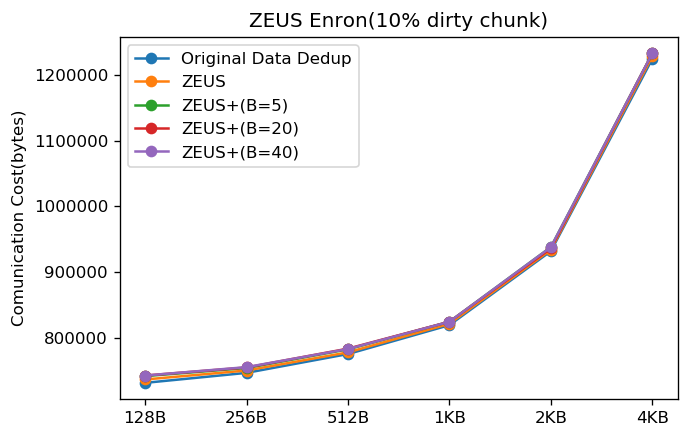

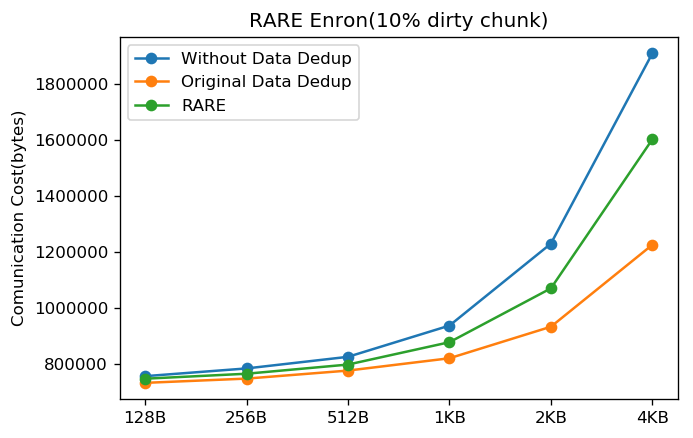

In [22]:
dirty10 = [origin_costs.copy(), zeus_costs.copy(), zeus5_costs.copy(), zeus20_costs.copy(), zeus40_costs.copy()]
dirty10_rare = [no_dedup_costs.copy(), origin_dedup_costs.copy(), rare_costs.copy()]

print("Origin Data Dedup:", origin_costs)
print("ZEUS:             ", zeus_costs)
print("ZEUS+(B=5):       ", zeus5_costs)
print("ZEUS+(B=20):      ", zeus20_costs)
print("ZEUS+(B=40):      ", zeus40_costs)
print('-------------')
print("Without Data Dedup:", no_dedup_costs)
print("Rare:              ", rare_costs)
print("Origin Data Dedup: ", origin_dedup_costs)

plt.figure(dpi = 120)
x = ['128B', '256B', '512B', '1KB', '2KB', '4KB']
plt.plot(x, origin_costs,  '-o', label = 'Original Data Dedup')
plt.plot(x, zeus_costs,  '-o', label = 'ZEUS')
plt.plot(x, zeus5_costs,  '-o', label = 'ZEUS+(B=5)')
plt.plot(x, zeus20_costs,  '-o', label = 'ZEUS+(B=20)')
plt.plot(x, zeus40_costs,  '-o', label = 'ZEUS+(B=40)')
plt.legend()
plt.ylabel('Comunication Cost(bytes)')
plt.title('ZEUS Enron(10% dirty chunk)')
plt.show()

plt.figure(dpi = 120)
plt.plot(x, no_dedup_costs, '-o', label = 'Without Data Dedup')
plt.plot(x, origin_dedup_costs, '-o', label = 'Original Data Dedup')
plt.plot(x, rare_costs, '-o', label = 'RARE')
plt.legend()
plt.ylabel('Comunication Cost(bytes)')
plt.title('RARE Enron(10% dirty chunk)')
plt.show()

In [23]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

origin_costs.clear()
zeus_costs.clear()
zeus5_costs.clear()
zeus20_costs.clear()
zeus40_costs.clear()

no_dedup_costs.clear()
origin_dedup_costs.clear()
rare_costs.clear()

# 25% dirty chunk 128B
upload_file(upload_files, 128)
cut_check_file(check_files, 128)
set_dirty_chunk(0.25)
origin_costs.append(cal_commu_cost(128, False, True, 0))
zeus_costs.append(cal_commu_cost(128, True, True, 0))
zeus5_costs.append(cal_commu_cost(128, True, True, 5))
zeus20_costs.append(cal_commu_cost(128, True, True, 20))
zeus40_costs.append(cal_commu_cost(128, True, True, 40))
no_dedup_costs.append(rare_cost(128, False, False, False))
origin_dedup_costs.append(rare_cost(128, True, False, True))
rare_costs.append(rare_cost(128, True, True, True))

dirty original dedup with chunk size: 128 bytes, dedup times: 164, check times: 5900, dedup percentage: 2.779661 %
dirty ZEUS with chunk size: 128 bytes, dedup times: 127, check times: 5900, dedup percentage: 2.152542 %
dirty ZEUS having threshold 5, with chunk size: 128 bytes, dedup times: 102, check times: 5900, dedup percentage: 1.728814 %
dirty ZEUS having threshold 20, with chunk size: 128 bytes, dedup times: 100, check times: 5900, dedup percentage: 1.694915 %
dirty ZEUS having threshold 40, with chunk size: 128 bytes, dedup times: 100, check times: 5900, dedup percentage: 1.694915 %
no dedup with chunk size: 128 bytes, dedup times: 0, check times: 5900, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 128 bytes, dedup times: 164, check times: 5900, dedup percentage: 2.779661 %
dirty RARE with chunk size: 128 bytes, dedup times: 64, check times: 5900, dedup percentage: 1.084746 %


In [24]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# 25% dirty chunk 256B
upload_file(upload_files, 256)
cut_check_file(check_files, 256)
set_dirty_chunk(0.25)
origin_costs.append(cal_commu_cost(256, False, True, 0))
zeus_costs.append(cal_commu_cost(256, True, True, 0))
zeus5_costs.append(cal_commu_cost(256, True, True, 5))
zeus20_costs.append(cal_commu_cost(256, True, True, 20))
zeus40_costs.append(cal_commu_cost(256, True, True, 40))
no_dedup_costs.append(rare_cost(256, False, False, False))
origin_dedup_costs.append(rare_cost(256, True, False, True))
rare_costs.append(rare_cost(256, True, True, True))

dirty original dedup with chunk size: 256 bytes, dedup times: 136, check times: 3058, dedup percentage: 4.447351 %
dirty ZEUS with chunk size: 256 bytes, dedup times: 123, check times: 3058, dedup percentage: 4.022237 %
dirty ZEUS having threshold 5, with chunk size: 256 bytes, dedup times: 110, check times: 3058, dedup percentage: 3.597122 %
dirty ZEUS having threshold 20, with chunk size: 256 bytes, dedup times: 110, check times: 3058, dedup percentage: 3.597122 %
dirty ZEUS having threshold 40, with chunk size: 256 bytes, dedup times: 108, check times: 3058, dedup percentage: 3.531720 %
no dedup with chunk size: 256 bytes, dedup times: 0, check times: 3058, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 256 bytes, dedup times: 136, check times: 3058, dedup percentage: 4.447351 %
dirty RARE with chunk size: 256 bytes, dedup times: 73, check times: 3058, dedup percentage: 2.387181 %


In [25]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# 25% dirty chunk 512B
upload_file(upload_files, 512)
cut_check_file(check_files, 512)
set_dirty_chunk(0.25)
origin_costs.append(cal_commu_cost(512, False, True, 0))
zeus_costs.append(cal_commu_cost(512, True, True, 0))
zeus5_costs.append(cal_commu_cost(512, True, True, 5))
zeus20_costs.append(cal_commu_cost(512, True, True, 20))
zeus40_costs.append(cal_commu_cost(512, True, True, 40))
no_dedup_costs.append(rare_cost(512, False, False, False))
origin_dedup_costs.append(rare_cost(512, True, False, True))
rare_costs.append(rare_cost(512, True, True, True))

dirty original dedup with chunk size: 512 bytes, dedup times: 93, check times: 1610, dedup percentage: 5.776398 %
dirty ZEUS with chunk size: 512 bytes, dedup times: 88, check times: 1610, dedup percentage: 5.465839 %
dirty ZEUS having threshold 5, with chunk size: 512 bytes, dedup times: 81, check times: 1610, dedup percentage: 5.031056 %
dirty ZEUS having threshold 20, with chunk size: 512 bytes, dedup times: 83, check times: 1610, dedup percentage: 5.155280 %
dirty ZEUS having threshold 40, with chunk size: 512 bytes, dedup times: 81, check times: 1610, dedup percentage: 5.031056 %
no dedup with chunk size: 512 bytes, dedup times: 0, check times: 1610, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 512 bytes, dedup times: 93, check times: 1610, dedup percentage: 5.776398 %
dirty RARE with chunk size: 512 bytes, dedup times: 34, check times: 1610, dedup percentage: 2.111801 %


In [26]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# 25% dirty chunk 1KB
upload_file(upload_files, 1024)
cut_check_file(check_files, 1024)
set_dirty_chunk(0.25)
origin_costs.append(cal_commu_cost(1024, False, True, 0))
zeus_costs.append(cal_commu_cost(1024, True, True, 0))
zeus5_costs.append(cal_commu_cost(1024, True, True, 5))
zeus20_costs.append(cal_commu_cost(1024, True, True, 20))
zeus40_costs.append(cal_commu_cost(1024, True, True, 40))
no_dedup_costs.append(rare_cost(1024, False, False, False))
origin_dedup_costs.append(rare_cost(1024, True, False, True))
rare_costs.append(rare_cost(1024, True, True, True))

dirty original dedup with chunk size: 1024 bytes, dedup times: 113, check times: 914, dedup percentage: 12.363239 %
dirty ZEUS with chunk size: 1024 bytes, dedup times: 111, check times: 914, dedup percentage: 12.144420 %
dirty ZEUS having threshold 5, with chunk size: 1024 bytes, dedup times: 109, check times: 914, dedup percentage: 11.925602 %
dirty ZEUS having threshold 20, with chunk size: 1024 bytes, dedup times: 109, check times: 914, dedup percentage: 11.925602 %
dirty ZEUS having threshold 40, with chunk size: 1024 bytes, dedup times: 109, check times: 914, dedup percentage: 11.925602 %
no dedup with chunk size: 1024 bytes, dedup times: 0, check times: 914, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 1024 bytes, dedup times: 113, check times: 914, dedup percentage: 12.363239 %
dirty RARE with chunk size: 1024 bytes, dedup times: 56, check times: 914, dedup percentage: 6.126915 %


In [27]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# 25% dirty chunk 2KB
upload_file(upload_files, 2048)
cut_check_file(check_files, 2048)
set_dirty_chunk(0.25)
origin_costs.append(cal_commu_cost(2048, False, True, 0))
zeus_costs.append(cal_commu_cost(2048, True, True, 0))
zeus5_costs.append(cal_commu_cost(2048, True, True, 5))
zeus20_costs.append(cal_commu_cost(2048, True, True, 20))
zeus40_costs.append(cal_commu_cost(2048, True, True, 40))
no_dedup_costs.append(rare_cost(2048, False, False, False))
origin_dedup_costs.append(rare_cost(2048, True, False, True))
rare_costs.append(rare_cost(2048, True, True, True))

dirty original dedup with chunk size: 2048 bytes, dedup times: 144, check times: 600, dedup percentage: 24.000000 %
dirty ZEUS with chunk size: 2048 bytes, dedup times: 143, check times: 600, dedup percentage: 23.833333 %
dirty ZEUS having threshold 5, with chunk size: 2048 bytes, dedup times: 142, check times: 600, dedup percentage: 23.666667 %
dirty ZEUS having threshold 20, with chunk size: 2048 bytes, dedup times: 141, check times: 600, dedup percentage: 23.500000 %
dirty ZEUS having threshold 40, with chunk size: 2048 bytes, dedup times: 141, check times: 600, dedup percentage: 23.500000 %
no dedup with chunk size: 2048 bytes, dedup times: 0, check times: 600, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 2048 bytes, dedup times: 144, check times: 600, dedup percentage: 24.000000 %
dirty RARE with chunk size: 2048 bytes, dedup times: 70, check times: 600, dedup percentage: 11.666667 %


In [28]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# 25% dirty chunk 4KB
upload_file(upload_files, 4096)
cut_check_file(check_files, 4096)
set_dirty_chunk(0.25)
origin_costs.append(cal_commu_cost(4096, False, True, 0))
zeus_costs.append(cal_commu_cost(4096, True, True, 0))
zeus5_costs.append(cal_commu_cost(4096, True, True, 5))
zeus20_costs.append(cal_commu_cost(4096, True, True, 20))
zeus40_costs.append(cal_commu_cost(4096, True, True, 40))
no_dedup_costs.append(rare_cost(4096, False, False, False))
origin_dedup_costs.append(rare_cost(4096, True, False, True))
rare_costs.append(rare_cost(4096, True, True, True))

dirty original dedup with chunk size: 4096 bytes, dedup times: 167, check times: 466, dedup percentage: 35.836910 %
dirty ZEUS with chunk size: 4096 bytes, dedup times: 166, check times: 466, dedup percentage: 35.622318 %
dirty ZEUS having threshold 5, with chunk size: 4096 bytes, dedup times: 165, check times: 466, dedup percentage: 35.407725 %
dirty ZEUS having threshold 20, with chunk size: 4096 bytes, dedup times: 165, check times: 466, dedup percentage: 35.407725 %
dirty ZEUS having threshold 40, with chunk size: 4096 bytes, dedup times: 165, check times: 466, dedup percentage: 35.407725 %
no dedup with chunk size: 4096 bytes, dedup times: 0, check times: 466, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 4096 bytes, dedup times: 167, check times: 466, dedup percentage: 35.836910 %
dirty RARE with chunk size: 4096 bytes, dedup times: 91, check times: 466, dedup percentage: 19.527897 %


Origin Data Dedup: [734208, 748032, 776704, 820224, 933888, 1224704]
ZEUS:              [738944, 751360, 779264, 822272, 935936, 1228800]
ZEUS+(B=5):        [742144, 754688, 782848, 824320, 937984, 1232896]
ZEUS+(B=20):       [742400, 754688, 781824, 824320, 940032, 1232896]
ZEUS+(B=40):       [742400, 755200, 782848, 824320, 940032, 1232896]
-------------
Without Data Dedup: [755200, 782848, 824320, 935936, 1228800, 1908736]
Rare:               [747008, 764160, 806912, 878592, 1085440, 1536000]
Origin Data Dedup:  [734208, 748032, 776704, 820224, 933888, 1224704]


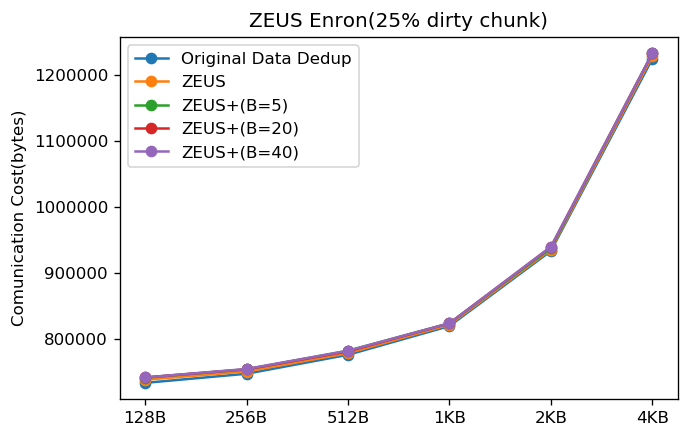

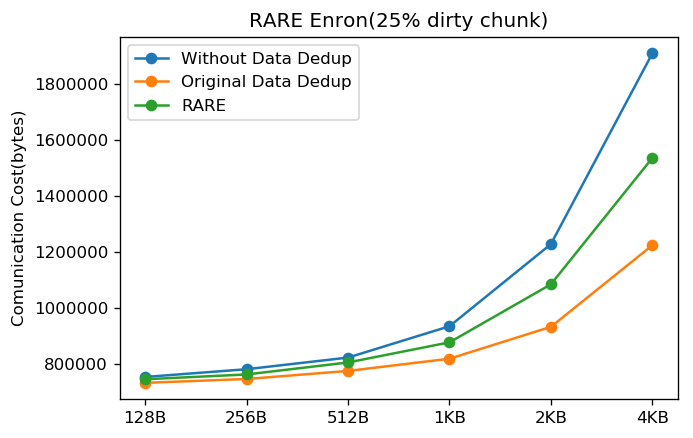

In [29]:
dirty25 = [origin_costs.copy(), zeus_costs.copy(), zeus5_costs.copy(), zeus20_costs.copy(), zeus40_costs.copy()]
dirty25_rare = [no_dedup_costs.copy(), origin_dedup_costs.copy(), rare_costs.copy()]

print("Origin Data Dedup:", origin_costs)
print("ZEUS:             ", zeus_costs)
print("ZEUS+(B=5):       ", zeus5_costs)
print("ZEUS+(B=20):      ", zeus20_costs)
print("ZEUS+(B=40):      ", zeus40_costs)
print('-------------')
print("Without Data Dedup:", no_dedup_costs)
print("Rare:              ", rare_costs)
print("Origin Data Dedup: ", origin_dedup_costs)

plt.figure(dpi = 120)
x = ['128B', '256B', '512B', '1KB', '2KB', '4KB']
plt.plot(x, origin_costs,  '-o', label = 'Original Data Dedup')
plt.plot(x, zeus_costs,  '-o', label = 'ZEUS')
plt.plot(x, zeus5_costs,  '-o', label = 'ZEUS+(B=5)')
plt.plot(x, zeus20_costs,  '-o', label = 'ZEUS+(B=20)')
plt.plot(x, zeus40_costs,  '-o', label = 'ZEUS+(B=40)')
plt.legend()
plt.ylabel('Comunication Cost(bytes)')
plt.title('ZEUS Enron(25% dirty chunk)')
plt.show()

plt.figure(dpi = 120)
plt.plot(x, no_dedup_costs, '-o', label = 'Without Data Dedup')
plt.plot(x, origin_dedup_costs, '-o', label = 'Original Data Dedup')
plt.plot(x, rare_costs, '-o', label = 'RARE')
plt.legend()
plt.ylabel('Comunication Cost(bytes)')
plt.title('RARE Enron(25% dirty chunk)')
plt.show()

no dirty chunk					 10% dirty chunk				 25% dirty chunk
ZEUS
['128B', '256B', '512B', '1KB', '2KB', '4KB']
[730496, 745216, 775168, 819200, 931840, 1224704] [731264, 746496, 775168, 819200, 931840, 1224704] [734208, 748032, 776704, 820224, 933888, 1224704]
[735616, 749056, 777728, 821248, 933888, 1228800] [736384, 750080, 777728, 821248, 933888, 1228800] [738944, 751360, 779264, 822272, 935936, 1228800]
[740992, 753408, 781824, 824320, 937984, 1232896] [741504, 753920, 782336, 824320, 937984, 1232896] [742144, 754688, 782848, 824320, 937984, 1232896]
[742272, 755456, 782848, 824320, 937984, 1232896] [742400, 754688, 783360, 824320, 935936, 1232896] [742400, 754688, 781824, 824320, 940032, 1232896]
[742144, 754944, 782848, 824320, 940032, 1232896] [742400, 755200, 782848, 824320, 937984, 1232896] [742400, 755200, 782848, 824320, 940032, 1232896]
--------------
RARE
[755200, 782848, 824320, 935936, 1228800, 1908736] [755200, 782848, 824320, 935936, 1228800, 1908736] [755200, 782848, 8243

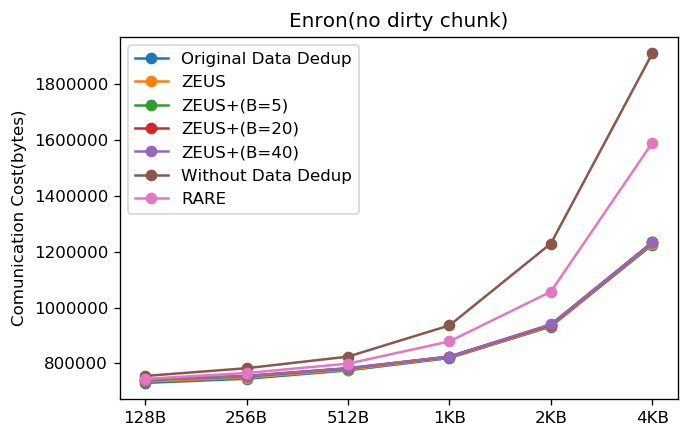

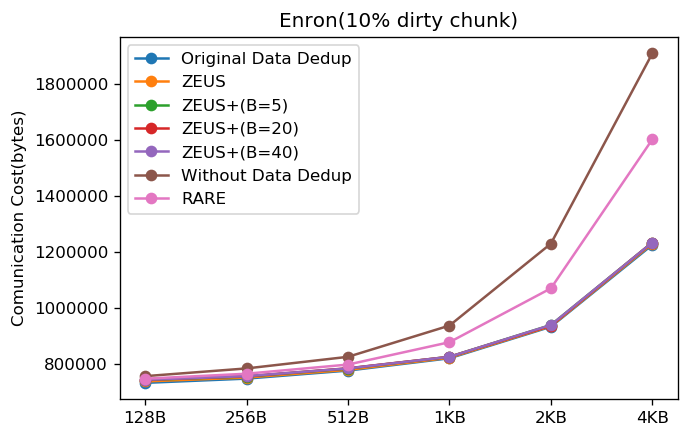

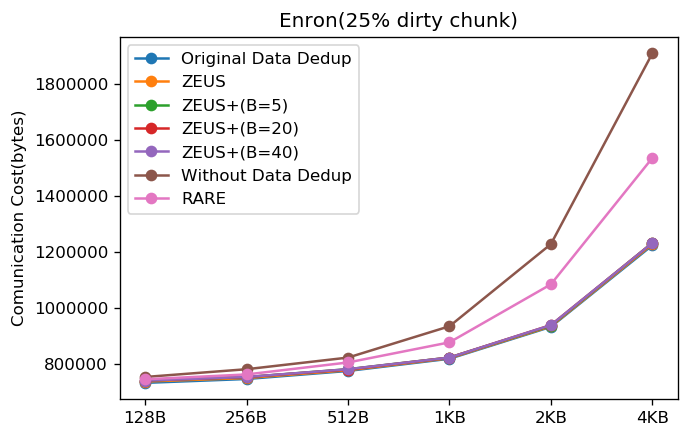

In [30]:
print('no dirty chunk\t\t\t\t\t', '10% dirty chunk\t\t\t\t', '25% dirty chunk')
print('ZEUS')
print(x)
for i in range(len(no_dirty)):
    print(no_dirty[i], dirty10[i], dirty25[i])
print('--------------')
print('RARE')
for i in range(len(no_dirty_rare)):
    print(no_dirty_rare[i], dirty10_rare[i], dirty25_rare[i])

plt.figure(dpi = 120)
x = ['128B', '256B', '512B', '1KB', '2KB', '4KB']
plt.plot(x, no_dirty[0],  '-o', label = 'Original Data Dedup')
plt.plot(x, no_dirty[1],  '-o', label = 'ZEUS')
plt.plot(x, no_dirty[2],  '-o', label = 'ZEUS+(B=5)')
plt.plot(x, no_dirty[3],  '-o', label = 'ZEUS+(B=20)')
plt.plot(x, no_dirty[4],  '-o', label = 'ZEUS+(B=40)')
plt.plot(x, no_dirty_rare[0], '-o', label = 'Without Data Dedup')
plt.plot(x, no_dirty_rare[2], '-o', label = 'RARE')
plt.legend()
plt.ylabel('Comunication Cost(bytes)')
plt.title('Enron(no dirty chunk)')
plt.show()
    
plt.figure(dpi = 120)
plt.plot(x, dirty10[0],  '-o', label = 'Original Data Dedup')
plt.plot(x, dirty10[1],  '-o', label = 'ZEUS')
plt.plot(x, dirty10[2],  '-o', label = 'ZEUS+(B=5)')
plt.plot(x, dirty10[3],  '-o', label = 'ZEUS+(B=20)')
plt.plot(x, dirty10[4],  '-o', label = 'ZEUS+(B=40)')
plt.plot(x, dirty10_rare[0], '-o', label = 'Without Data Dedup')
plt.plot(x, dirty10_rare[2], '-o', label = 'RARE')
plt.legend()
plt.ylabel('Comunication Cost(bytes)')
plt.title('Enron(10% dirty chunk)')
plt.show()

plt.figure(dpi = 120)
x = ['128B', '256B', '512B', '1KB', '2KB', '4KB']
plt.plot(x, origin_costs,  '-o', label = 'Original Data Dedup')
plt.plot(x, zeus_costs,  '-o', label = 'ZEUS')
plt.plot(x, zeus5_costs,  '-o', label = 'ZEUS+(B=5)')
plt.plot(x, zeus20_costs,  '-o', label = 'ZEUS+(B=20)')
plt.plot(x, zeus40_costs,  '-o', label = 'ZEUS+(B=40)')
plt.plot(x, dirty25_rare[0], '-o', label = 'Without Data Dedup')
plt.plot(x, dirty25_rare[2], '-o', label = 'RARE')
plt.legend()
plt.ylabel('Comunication Cost(bytes)')
plt.title('Enron(25% dirty chunk)')
plt.show()

# plt.subplot(131)
# plt.figure(dpi = 120)
# x = ['128B', '256B', '512B', '1KB', '2KB', '4KB']
# plt.plot(x, no_dirty[0],  '-o', label = 'Original Data Dedup')
# plt.plot(x, no_dirty[1],  '-o', label = 'ZEUS')
# plt.plot(x, no_dirty[2],  '-o', label = 'ZEUS+(B=5)')
# plt.plot(x, no_dirty[3],  '-o', label = 'ZEUS+(B=20)')
# plt.plot(x, no_dirty[4],  '-o', label = 'ZEUS+(B=40)')
# plt.legend()
# plt.ylabel('Comunication Cost(bytes)')
# plt.title('ZEUS Enron(no dirty chunk)')
# plt.show()

# plt.subplot(132)
# plt.figure(dpi = 120)
# plt.plot(x, dirty10[0],  '-o', label = 'Original Data Dedup')
# plt.plot(x, dirty10[1],  '-o', label = 'ZEUS')
# plt.plot(x, dirty10[2],  '-o', label = 'ZEUS+(B=5)')
# plt.plot(x, dirty10[3],  '-o', label = 'ZEUS+(B=20)')
# plt.plot(x, dirty10[4],  '-o', label = 'ZEUS+(B=40)')
# plt.legend()
# plt.ylabel('Comunication Cost(bytes)')
# plt.title('ZEUS Enron(10% dirty chunk)')
# plt.show()

# plt.subplot(133)
# plt.figure(dpi = 120)
# x = ['128B', '256B', '512B', '1KB', '2KB', '4KB']
# plt.plot(x, origin_costs,  '-o', label = 'Original Data Dedup')
# plt.plot(x, zeus_costs,  '-o', label = 'ZEUS')
# plt.plot(x, zeus5_costs,  '-o', label = 'ZEUS+(B=5)')
# plt.plot(x, zeus20_costs,  '-o', label = 'ZEUS+(B=20)')
# plt.plot(x, zeus40_costs,  '-o', label = 'ZEUS+(B=40)')
# plt.legend()
# plt.ylabel('Comunication Cost(bytes)')
# plt.title('ZEUS Enron(25% dirty chunk)')
# plt.show()

# plt.subplot(131)
# plt.figure(dpi = 120)
# plt.plot(x, no_dirty_rare[0], '-o', label = 'Without Data Dedup')
# plt.plot(x, no_dirty_rare[1], '-o', label = 'Original Data Dedup')
# plt.plot(x, no_dirty_rare[2], '-o', label = 'RARE')
# plt.legend()
# plt.ylabel('Comunication Cost(bytes)')
# plt.title('RARE Enron(no dirty chunk)')
# plt.show()

# plt.subplot(232)
# plt.figure(dpi = 120)
# plt.plot(x, dirty10_rare[0], '-o', label = 'Without Data Dedup')
# plt.plot(x, dirty10_rare[1], '-o', label = 'Original Data Dedup')
# plt.plot(x, dirty10_rare[2], '-o', label = 'RARE')
# plt.legend()
# plt.ylabel('Comunication Cost(bytes)')
# plt.title('RAER Enron(10% dirty chunk)')
# plt.show()

# plt.subplot(233)
# plt.figure(dpi = 120)
# plt.plot(x, dirty25_rare[0], '-o', label = 'Without Data Dedup')
# plt.plot(x, dirty25_rare[1], '-o', label = 'Original Data Dedup')
# plt.plot(x, dirty25_rare[2], '-o', label = 'RARE')
# plt.legend()
# plt.ylabel('Comunication Cost(bytes)')
# plt.title('RARE Enron(25% dirty chunk)')
# plt.show()